# Demonstration: QCNN algorithm

In [11]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars

import sys
sys.path.insert(0, '../')
import vqe as vqe
import qcnn as qcnn
import losses as losses
import visualization as qplt
##############

from jax.example_libraries import optimizers

In [12]:
class qcnn_ex:
    def __init__(self, vqe, qcnn_circuit, n_outputs = 1):
        """
        Class for the QCNN algorithm

        Parameters
        ----------
        vqe : class
            VQE class
        qcnn_circuit :
            Function of the QCNN circuit
        n_outputs : int
            Output vector dimension
        """
        self.vqe = vqe
        self.N = vqe.N
        self.n_states = vqe.n_states
        self.n_outputs = n_outputs
        self.qcnn_circuit_fun = lambda p: qcnn_circuit(p, self.N, n_outputs)
        self.n_params, self.final_active_wires = self.qcnn_circuit_fun([0] * 10000)
        self.params = np.array(np.random.rand(self.n_params) )
        self.device = vqe.device

        self.vqe_params = np.array(vqe.vqe_params)
        try:
            self.vqe_params1 = np.array(vqe.vqe_params1)
        except:
            pass
        self.labels = np.array(vqe.Hs.labels)
        self.train_index = []
        self.loss_train = []
        self.loss_test = []

        @qml.qnode(self.device, interface="jax")
        def circuit_drawer(self):
            _, active_wires = self.qcnn_circuit_fun(np.arange(self.n_params))
            if n_outputs == 1:
                return qml.probs(wires=self.N - 1)
            else:
                return [qml.probs(wires=int(k)) for k in active_wires]
            
        self.drawer = qml.draw(circuit_drawer)(self)
    
    def vqe_qcnn_circuit(self, vqe_p, qcnn_p):
        self.vqe.circuit(vqe_p)
        self.qcnn_circuit_fun(qcnn_p)
        
    def psi_qcnn_circuit(self, psi, qcnn_p):
        qml.QubitStateVector(psi, wires=[int(k) for k in range(self.N)])
        self.qcnn_circuit_fun(qcnn_p)
    
    # Training function
    def train(self, lr, n_epochs, train_index, loss_fn, circuit=False, plot=False, inject = False, excited = False):
        """
        Training function for the QCNN.

        Parameters
        ----------
        lr : float
            Learning rate for the ADAM optimizer
        n_epochs : int
            Total number of epochs for each learning
        train_index : np.ndarray
            Index of training points
        loss_fn : function
            Loss function
        circuit : bool
            if True -> Prints the circuit
        plot : bool
            if True -> It displays loss curve
        inject : bool
            if True -> Exact ground states will be computed and used as input
        """

        if not excited:
            vqe_params = self.vqe_params
        else:
            vqe_params = self.vqe_params1
            
        if None not in self.labels:
            X_train, Y_train = jnp.array(vqe_params[train_index]), jnp.array(
                self.labels[train_index]
            )
            test_index = np.setdiff1d(np.arange(len(vqe_params)), train_index)
            X_test, Y_test = jnp.array(vqe_params[test_index]), jnp.array(
                self.labels[test_index]
            )
        else:
            mask = jnp.array(jnp.logical_or(jnp.array(self.vqe.Hs.model_params)[:,1] == 0, jnp.array(self.vqe.Hs.model_params)[:,2] == 0))
            #mask = jnp.array(self.vqe.Hs.model_params)[:,1] == 0
            vqe_params = jnp.array(vqe_params)
            
            #mask = jnp.array(myqcnn.vqe.Hs.model_params)[:,1] == 0
            X, Y = vqe_params[mask], self.labels[mask,:].astype(int)
            test_index = np.setdiff1d(np.arange(len(Y)), train_index)
            
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test   = X[test_index], Y[test_index]
            
        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            print(self.drawer)

        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(vqe_p, qcnn_p):
            self.vqe_qcnn_circuit(vqe_p, qcnn_p)

            if self.n_outputs == 1:
                return qml.probs(wires=self.N - 1)
            else:
                return [qml.probs(wires=int(k)) for k in self.final_active_wires]
        
        params = copy.copy(self.params)

        if inject:
            psi = []
            for h in self.vqe.Hs.mat_Hs:
                # Compute eigenvalues and eigenvectors
                eigval, eigvec = jnp.linalg.eigh(h)
                # Get the eigenstate to the lowest eigenvalue
                gstate = eigvec[:,jnp.argmin(eigval)]

                psi.append(gstate)
            psi = jnp.array(psi)
            self.psi = psi
            
            X_train = jnp.array(psi[train_index])
            test_index = np.setdiff1d(np.arange(len(psi)), train_index)
            X_test  = jnp.array(psi[test_index])

            @qml.qnode(self.device, interface="jax")
            def qcnn_circuit_prob(psi, qcnn_p):
                self.psi_qcnn_circuit(psi, qcnn_p)

                if self.n_outputs == 1:
                    return qml.probs(wires=self.N - 1)
                else:
                    return [qml.probs(wires=int(k)) for k in self.final_active_wires]
        
        # Gradient of the Loss function
        jd_loss_fn = jax.jit(
            jax.grad(lambda p: loss_fn(X_train, Y_train, p, qcnn_circuit_prob))
        )

        def update(params, opt_state):
            grads = jd_loss_fn(params)
            opt_state = opt_update(0, grads, opt_state)
            
            return get_params(opt_state), opt_state
        
        # Compute Loss of whole sets
        train_loss_fn = jax.jit(
            lambda p: loss_fn(X_train, Y_train, p, qcnn_circuit_prob)
        )
        test_loss_fn = jax.jit(
            lambda p: loss_fn(X_test, Y_test, p, qcnn_circuit_prob)
        )

        progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)

        # Defining an optimizer in Jax
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(params)
        
        loss_history = []
        loss_history_test = []
        for epoch in range(n_epochs):
            params, opt_state = update(params, opt_state)

            if epoch % 100 == 0:
                loss_history.append(train_loss_fn(params))
                if len(Y_test) > 0:
                    loss_history_test.append(test_loss_fn(params))
            progress.update(1)
            progress.set_description("Cost: {0}".format(loss_history[-1]))

        self.loss_train = loss_history
        self.loss_test = loss_history_test
        self.params = params
        self.train_index = train_index
        self.circuit = self.vqe_qcnn_circuit if inject == False else self.psi_qcnn_circuit
        
        if plot:
            plt.figure(figsize=(15, 5))
            plt.plot(
                np.arange(len(loss_history)) * 100,
                np.asarray(loss_history),
                label="Training Loss",
            )
            if len(X_test) > 0:
                plt.plot(
                    np.arange(len(loss_history_test)) * 100,
                    np.asarray(loss_history_test),
                    label="Test Loss",
                )
            plt.axhline(y=0, color="r", linestyle="--")
            plt.title("Loss history")
            plt.ylabel("Average Cross entropy")
            plt.xlabel("Epoch")
            plt.grid(True)
            plt.legend()

In [13]:
def show_QCNN_classification1D(qcnnclass, inject = False, excited = False):
    """
    Plots performance of the classifier on the whole data
    """
    train_index = qcnnclass.train_index

    circuit = qcnnclass.vqe_qcnn_circuit if inject == False else qcnnclass.psi_qcnn_circuit
    
    @qml.qnode(qcnnclass.device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params):
        circuit(params_vqe, params)

        return qml.probs(wires=qcnnclass.N - 1)

    test_index = np.setdiff1d(np.arange(len(qcnnclass.vqe_params)), train_index)

    predictions_train = []
    predictions_test = []

    colors_train = []
    colors_test = []

    vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    
    if not inject:
        if excited:
            predictions = vcircuit(qcnnclass.vqe_params1)[:, 1]
        else: 
            predictions = vcircuit(qcnnclass.vqe_params)[:, 1]
    else:
        try:
            qcnnclass.psi
        except:
            psi = []
            for h in qcnnclass.vqe.Hs.mat_Hs:
                # Compute eigenvalues and eigenvectors
                eigval, eigvec = jnp.linalg.eigh(h)
                # Get the eigenstate to the lowest eigenvalue
                gstate = eigvec[:,jnp.argmin(eigval)]

                psi.append(gstate)
            psi = jnp.array(psi)
            qcnnclass.psi = psi
            
        predictions = vcircuit(qcnnclass.psi)[:, 1]

    for i, prediction in enumerate(predictions):
        # if data in training set
        if i in train_index:
            predictions_train.append(prediction)
            if np.round(prediction) == 0:
                colors_train.append("green") if qcnnclass.labels[
                    i
                ] == 0 else colors_train.append("red")
            else:
                colors_train.append("red") if qcnnclass.labels[
                    i
                ] == 0 else colors_train.append("green")
        else:
            predictions_test.append(prediction)
            if np.round(prediction) == 0:
                colors_test.append("green") if qcnnclass.labels[
                    i
                ] == 0 else colors_test.append("red")
            else:
                colors_test.append("red") if qcnnclass.labels[
                    i
                ] == 0 else colors_test.append("green")

    fig, ax = plt.subplots(2, 1, figsize=(16, 10))

    ax[0].set_xlim(-0.1, 2.1)
    ax[0].set_ylim(0, 1)
    ax[0].grid(True)
    ax[0].axhline(y=0.5, color="gray", linestyle="--")
    ax[0].axvline(x=1, color="gray", linestyle="--")
    ax[0].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
    ax[0].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
    #ax[0].set_xlabel("Transverse field")
    ax[0].set_ylabel("Prediction of label II")
    ax[0].set_title("Predictions of labels; J = 1")
    ax[0].scatter(
        2 * np.sort(train_index) / len(qcnnclass.vqe_params),
        predictions_train,
        c="royalblue",
        label="Training samples",
    )
    ax[0].scatter(
        2 * np.sort(test_index) / len(qcnnclass.vqe_params),
        predictions_test,
        c="orange",
        label="Test samples",
    )
    ax[0].legend()

    ax[1].set_xlim(-0.1, 2.1)
    ax[1].set_ylim(0, 1)
    ax[1].grid(True)
    ax[1].axhline(y=0.5, color="gray", linestyle="--")
    ax[1].axvline(x=1, color="gray", linestyle="--")
    ax[1].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
    ax[1].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
    #ax[1].set_xlabel("Transverse field")
    ax[1].set_ylabel("Prediction of label II")
    ax[1].set_title("Predictions of labels; J = 1")
    ax[1].scatter(
        2 * np.sort(train_index) / len(qcnnclass.vqe_params),
        predictions_train,
        c=colors_train,
    )
    ax[1].scatter(
        2 * np.sort(test_index) / len(qcnnclass.vqe_params),
        predictions_test,
        c=colors_test,
    )
    

In [14]:
myqcnn = qcnn_ex(vqe.load_vqe('../data/vqe_isingchain.pkl'), qcnn.qcnn_circuit)
train_index = np.random.choice(np.arange(len(myqcnn.vqe_params)), 100, replace = False)
myqcnn.train(1, 4000, train_index, losses.cross_entropy, circuit=True, plot=False, excited = True)

+--- CIRCUIT ---+
0: ──||──||──RX(0.00)──RY(8.00)──╭C──RX(16.00)──H──RX(24.00)──RY(32.00)──────────────────────
1: ──||──||──RX(1.00)──RY(9.00)──╰X────────────╭C──RX(20.00)──H──────────RX(25.00)──RY(33.00)
2: ──||──||──RX(2.00)──RY(10.00)─╭C──RX(17.00)─╰X──H──────────RX(26.00)──RY(34.00)───────────
3: ──||──||──RX(3.00)──RY(11.00)─╰X────────────╭C──RX(21.00)──H──────────RX(27.00)──RY(35.00)
4: ──||──||──RX(4.00)──RY(12.00)─╭C──RX(18.00)─╰X──H──────────RX(28.00)──RY(36.00)───────────
5: ──||──||──RX(5.00)──RY(13.00)─╰X────────────╭C──RX(22.00)──H──────────RX(29.00)──RY(37.00)
6: ──||──||──RX(6.00)──RY(14.00)─╭C──RX(19.00)─╰X──H──────────RX(30.00)──RY(38.00)─╭C────────
7: ──||──||──RX(7.00)──RY(15.00)─╰X──RX(23.00)──H──RX(31.00)──RY(39.00)────────────╰X────────

──╭C──────────RX(40.00)────────────────────────||─╭C─────────────────────────
──╰X────────────────────╭C──────────RX(44.00)──||─╰ControlledOperation(48.00)
──╭C──────────RX(41.00)─╰X─────────────────────||─╭C─────────────────────

Cost: 0.30709782242774963: 100%|████████████| 4000/4000 [00:52<00:00, 76.31it/s]


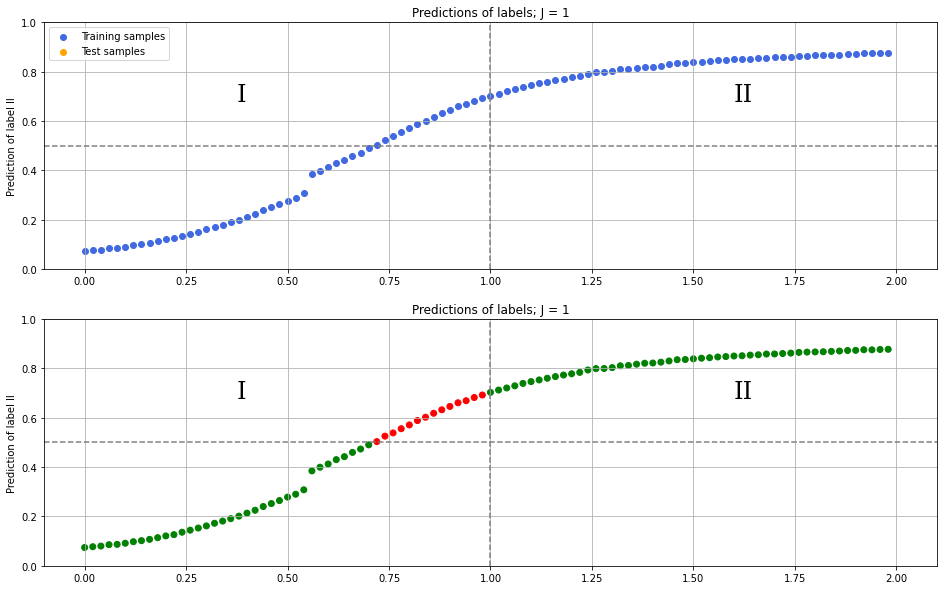

In [16]:
show_QCNN_classification1D(myqcnn, inject = False, excited = False)

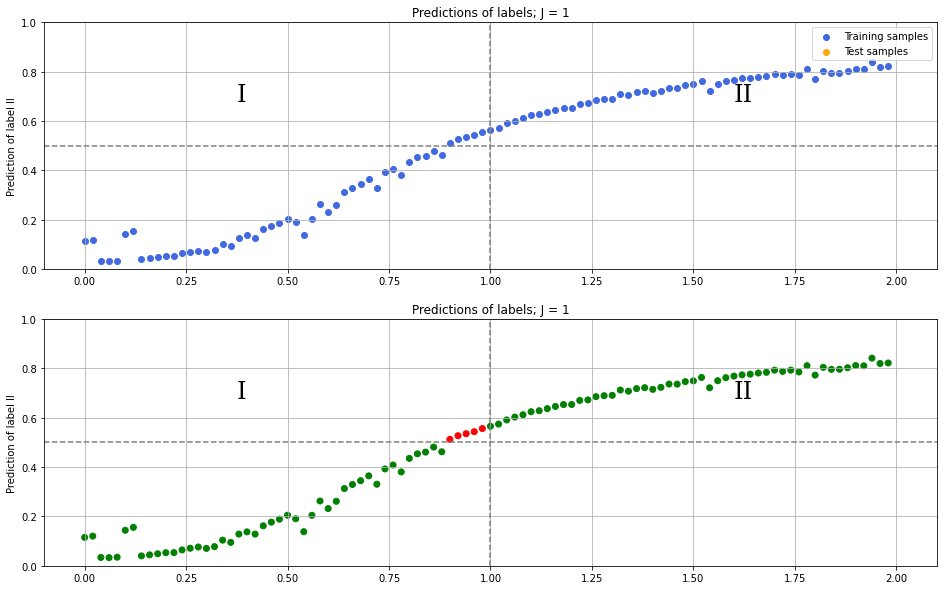

In [17]:
show_QCNN_classification1D(myqcnn, inject = False, excited = True)

In [18]:
myqcnn = qcnn_ex(vqe.load_vqe('../data/vqe_isingchain.pkl'), qcnn.qcnn_circuit)
train_index = np.random.choice(np.arange(len(myqcnn.vqe_params)), 100, replace = False)
myqcnn.train(1, 4000, train_index, losses.cross_entropy, circuit=True, plot=False, excited = False)

+--- CIRCUIT ---+
0: ──||──||──RX(0.00)──RY(8.00)──╭C──RX(16.00)──H──RX(24.00)──RY(32.00)──────────────────────
1: ──||──||──RX(1.00)──RY(9.00)──╰X────────────╭C──RX(20.00)──H──────────RX(25.00)──RY(33.00)
2: ──||──||──RX(2.00)──RY(10.00)─╭C──RX(17.00)─╰X──H──────────RX(26.00)──RY(34.00)───────────
3: ──||──||──RX(3.00)──RY(11.00)─╰X────────────╭C──RX(21.00)──H──────────RX(27.00)──RY(35.00)
4: ──||──||──RX(4.00)──RY(12.00)─╭C──RX(18.00)─╰X──H──────────RX(28.00)──RY(36.00)───────────
5: ──||──||──RX(5.00)──RY(13.00)─╰X────────────╭C──RX(22.00)──H──────────RX(29.00)──RY(37.00)
6: ──||──||──RX(6.00)──RY(14.00)─╭C──RX(19.00)─╰X──H──────────RX(30.00)──RY(38.00)─╭C────────
7: ──||──||──RX(7.00)──RY(15.00)─╰X──RX(23.00)──H──RX(31.00)──RY(39.00)────────────╰X────────

──╭C──────────RX(40.00)────────────────────────||─╭C─────────────────────────
──╰X────────────────────╭C──────────RX(44.00)──||─╰ControlledOperation(48.00)
──╭C──────────RX(41.00)─╰X─────────────────────||─╭C─────────────────────

Cost: 0.20809504389762878: 100%|████████████| 4000/4000 [00:51<00:00, 77.15it/s]


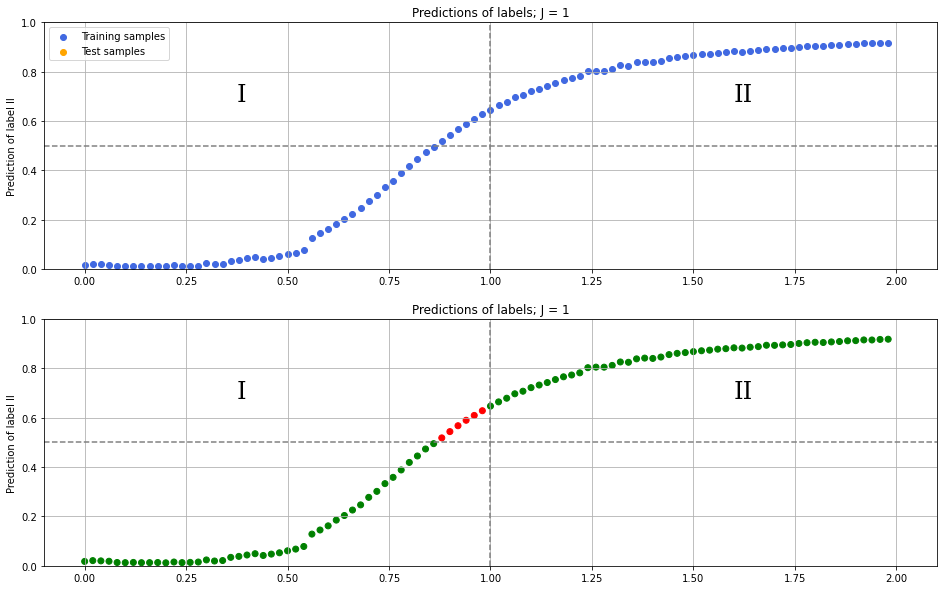

In [19]:
show_QCNN_classification1D(myqcnn, inject = False, excited = False)

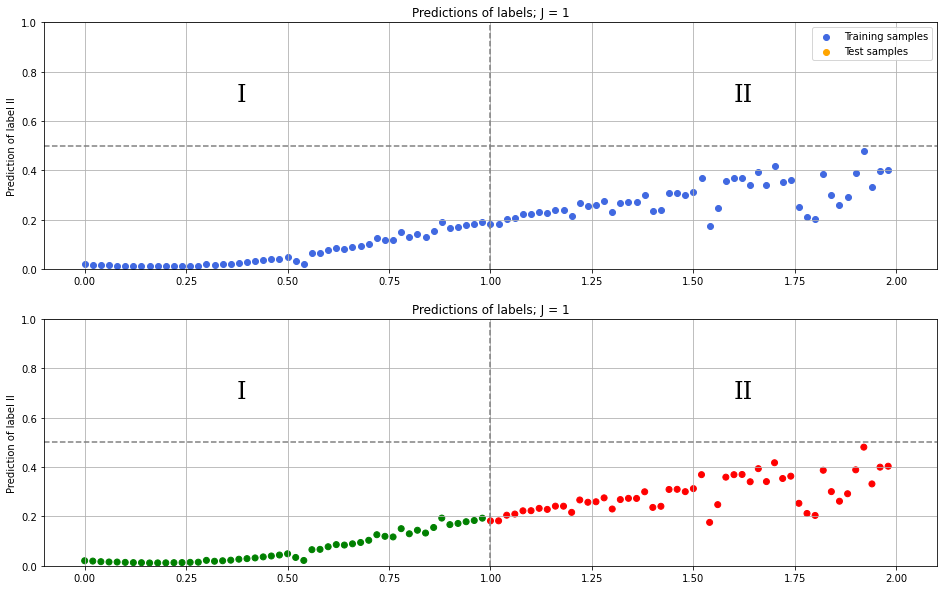

In [20]:
show_QCNN_classification1D(myqcnn, inject = False, excited = True)